In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.utils import to_categorical  # Import to_categorical from keras.utils
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1_l2,l1,l2
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.utils.class_weight import compute_class_weight

In [22]:
def configure_model(inp_shape,num_classes):
    # Build the deep learning model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='leaky_relu',input_shape=inp_shape),
        tf.keras.layers.Dense(32, activation='leaky_relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # # Define a custom learning rate schedule function
    # def lr_schedule(epoch):
    #     if epoch < 10:
    #         return 0.001
    #     elif epoch < 20:
    #         return 0.0001
    #     else:
    #         return 0.00001

    custom_optimizer = Adam(learning_rate=0.001)
    return model,custom_optimizer


In [23]:
def model_test(model,custom_optimizer,X_train,y_train,X_test,y_test):
    
    # Compile the model with sparse-categorical cross-entropy loss
    model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history=model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.25, verbose=0)
    y_pred = model.predict(X_test)
    y_pred_class = y_pred.argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred_class)

    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    return y_pred_class,history
# for one-hot encoded labels
# # Method 1: Using scikit-learn's accuracy_score
# # Convert one-hot encoded labels to class labels
# y_test_class = y_test1.argmax(axis=1)
# y_pred_class = model.predict(X_test1).argmax(axis=1)

# # Calculate accuracy
# accuracy = accuracy_score(y_test_class, y_pred_class)
# print(f'Accuracy (Method 1): {accuracy * 100:.2f}%')

# # Method 2: Using Keras's categorical_accuracy metric
# # Compile the model with 'categorical_accuracy' as a metric
# model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# # Train the model
# history = model.fit(X_train1, y_train1, epochs=100, batch_size=64, validation_split=0.25, verbose=0)

# # Access the final training accuracy from history
# final_accuracy = history.history['categorical_accuracy'][-1]
# print(f'Accuracy (Method 2): {final_accuracy * 100:.2f}%')

In [24]:
def cal_confusion_matrix(y_test,y_pred):
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate sensitivity and specificity
    true_positive = conf_matrix[1, 1]
    false_positive = conf_matrix[0, 1]
    true_negative = conf_matrix[0, 0]
    false_negative = conf_matrix[1, 0]

    print("true positive",true_positive)
    print("false positive",false_positive)
    print("true negative",true_negative)
    print("false negative",false_negative)
    
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)

    print(f'Sensitivity:(Recall) {sensitivity * 100:.2f}%')
    print(f'Specificity: {specificity * 100:.2f}%')


    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 Score: {f1:.2f}')

    # Calculate precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision: {precision:.2f}')

    return conf_matrix


In [25]:
def plot_conf_matrix(conf_matrix,classes):
    normalize=True
    title='Confusion matrix'
    cmap=plt.cm.Blues
    cm=conf_matrix
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    print(thresh)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    plt.show()

In [26]:
def plot_loss_curve(history):

    # Access the loss and validation loss from the training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create an array of the same length as the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot the loss and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [27]:
#for reading dataset-1
# Load your CSV data1 using pandas
data1 = pd.read_csv('classData.csv')

# Combine the values of the first 4 columns into a new column
data1['Combination'] = data1.apply(lambda row: ''.join(map(str, row[:4])), axis=1)

# Find unique combinations and assign label numbers
unique_combinations = data1['Combination'].unique()
label_mapping = {combination: label for label, combination in enumerate(unique_combinations)}

# Add a new column with the label numbers
data1['Label'] = data1['Combination'].map(label_mapping)

X1 = data1.iloc[:, 4:10].values  # Features
y1 = data1.iloc[:, 11:].values  # Labels

# Standardize the data
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

# One-hot encode the labels
# y1_encoded = to_categorical(y1, num_classes=6)
num_classes=6
y1_encoded = y1

50/50 [==============================] - 0s 1ms/step
Accuracy: 86.84%
true positive 226
false positive 0
true negative 241
false negative 11
Sensitivity:(Recall) 95.36%
Specificity: 100.00%
F1 Score: 0.85
Precision: 0.87
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.05 0.95 0.   0.   0.   0.  ]
 [0.   0.   0.99 0.   0.   0.01]
 [0.   0.   0.01 0.19 0.8  0.  ]
 [0.   0.01 0.01 0.13 0.85 0.  ]
 [0.   0.   0.   0.   0.   1.  ]]
0.5


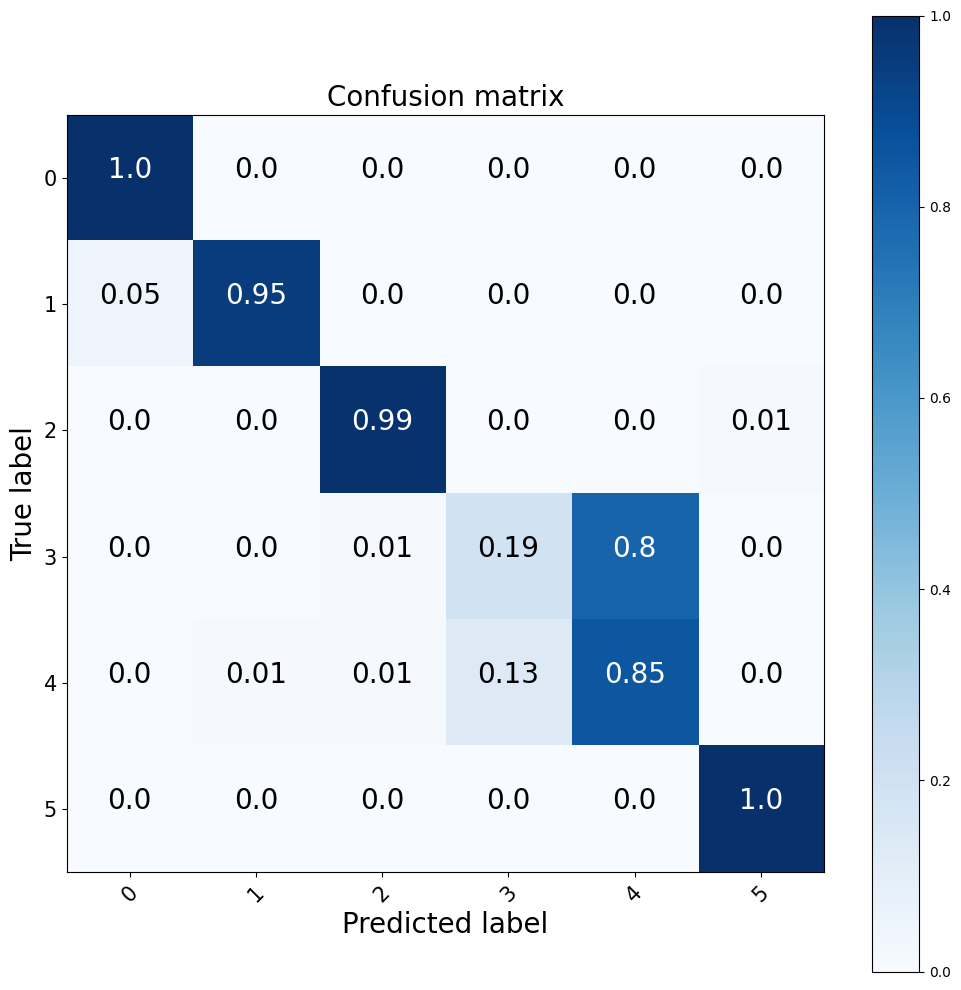

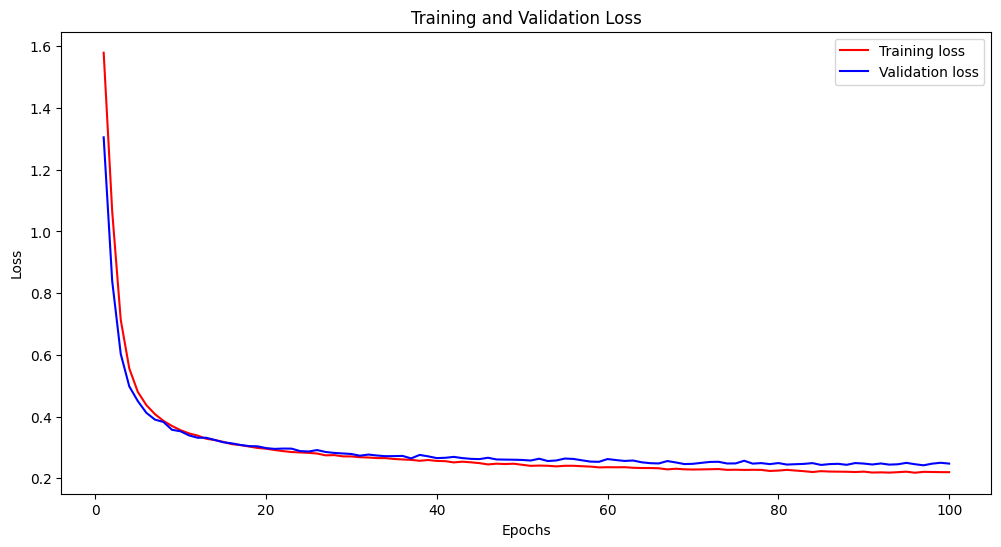

In [28]:
#Compiling and testing model for dataset-1

#Splitting dataset-1 into train and test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1_encoded, test_size=0.2, random_state=42)
input_shape1=(X_train1.shape[1],)
num_classes=6
model1,custom_optimizer=configure_model(input_shape1,num_classes)
y_pred1,history1=model_test(model1,custom_optimizer,X_train1,y_train1,X_test1,y_test1)
conf_matrix1=cal_confusion_matrix(y_test1,y_pred1)
plot_conf_matrix(conf_matrix1,classes=['0','1','2','3','4','5'])
plot_loss_curve(history1)


In [29]:
#Dataset preprocessing for dataset-2

# Load your CSV data using pandas
data2 = pd.read_csv('cwru_bearing.csv')
import pandas as pd

# Step 1: Identify unique labels in the last column
unique_labels = data2['fault'].unique()

# Step 2: Create a mapping from labels to numbers
label_to_number = {label: index for index, label in enumerate(unique_labels)}

# Step 3: Replace labels with corresponding numbers
data2['fault'] = data2['fault'].map(label_to_number)

# Now, 'Y' contains numeric labels from 1 to 11

# You can save the modified DataFrame to a new CSV file if needed
# data2.to_csv('cwru_bearing_numeric_labels.csv', index=False)
# Standardize the data

X2 = data2.iloc[:, 0:9].values  # Features
y2 = data2.iloc[:, 9].values  # Labels

# Standardize the data
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)


15/15 [==============================] - 0s 2ms/step
Accuracy: 93.91%
true positive 45
false positive 0
true negative 43
false negative 0
Sensitivity:(Recall) 100.00%
Specificity: 100.00%
F1 Score: 0.94
Precision: 0.94
Normalized confusion matrix
[[0.93 0.   0.   0.   0.   0.   0.   0.07 0.   0.  ]
 [0.   0.9  0.02 0.   0.   0.   0.   0.04 0.   0.04]
 [0.02 0.   0.82 0.   0.   0.04 0.   0.12 0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.02 0.98 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.06 0.02 0.   0.   0.   0.   0.93 0.   0.  ]
 [0.   0.   0.   0.02 0.   0.   0.02 0.   0.96 0.  ]
 [0.   0.1  0.   0.   0.   0.   0.   0.   0.   0.9 ]]
0.5


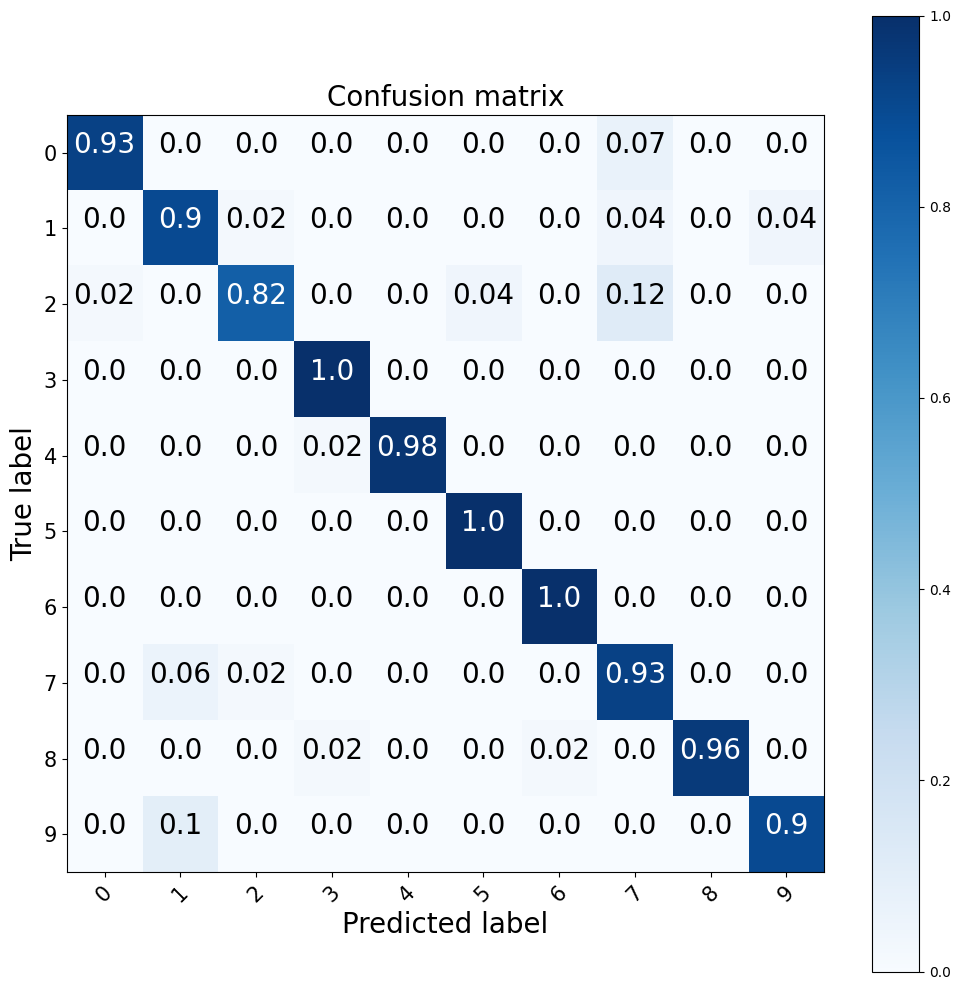

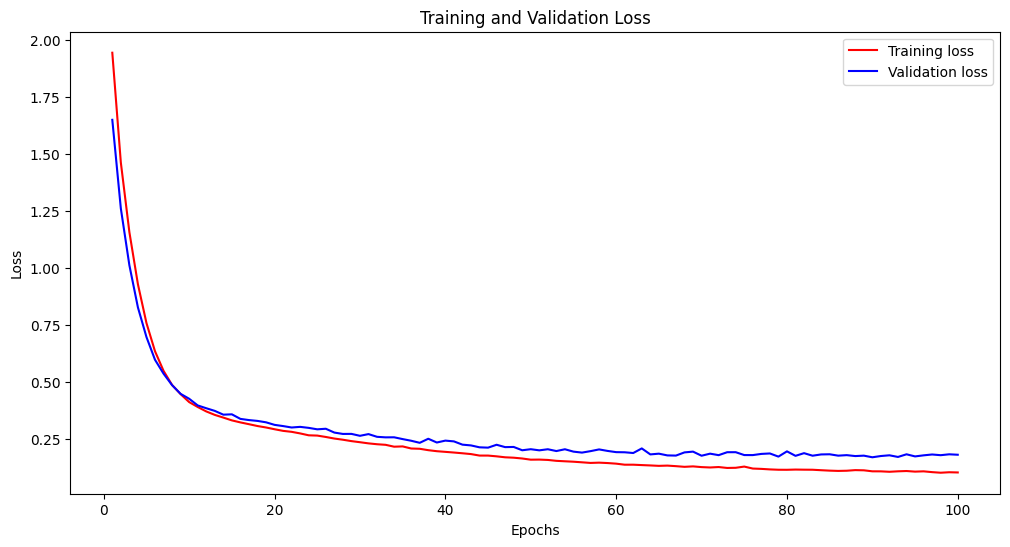

In [30]:
#Compiling and testing model for dataset-2

#Splitting dataset-2 into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
input_shape2=(X_train2.shape[1],)
num_classes=10
model2,custom_optimizer=configure_model(input_shape2,num_classes)
y_pred2,history2=model_test(model2,custom_optimizer,X_train2,y_train2,X_test2,y_test2)
conf_matrix2=cal_confusion_matrix(y_test2,y_pred2)
plot_conf_matrix(conf_matrix2,classes=['0','1','2','3','4','5','6','7','8','9'])
plot_loss_curve(history2)
